# Aggregate generated networks

In [1]:
import os
import random
import re
import sys
import tempfile
import time
import warnings

import numpy as np
import networkx as nx
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import ScalarFormatter
import scipy.interpolate
import scipy.stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest

sys.path.append('../..')
import aggregate_networks
import chip_validation2

pd.set_option('display.precision', 2)
%matplotlib inline

---

## Read in all the networks we want to include

In [2]:
annotation_df = pd.read_csv('../../../Papers/Mycobacterium_tuberculosis_H37Rv_txt_v5.txt',
    sep='\t', index_col=None, usecols=['Locus'])
annotation_df = annotation_df[~annotation_df['Locus'].str.startswith('MTB')]
annotation_df

,Locus
56,Rv2007c
57,Rv3451
58,Rv3452
59,Rv2658c
60,Rv2612c
...,...
4182,Rv3216
4183,Rv3924c
4184,Rv0277A
4185,Rv2427A


In [9]:
top3_network_df = pd.read_csv('archive/aggregate-mtb_20240722_top3_trunc.txt',
    sep='\t', header=None, index_col=None, names=['Regulator', 'Gene', 'Rank'])
top3_network_df

,Regulator,Gene,Rank
0,Rv2989,Rv2988c,1.0
1,Rv3095,Rv3094c,2.0
2,Rv2989,Rv2987c,3.0
3,Rv3095,Rv3093c,4.0
4,Rv0081,Rv0085,5.0
...,...,...,...
317516,Rv0054,Rv0039c,317517.0
317517,Rv1990c,Rv2448c,317518.0
317518,Rv1560,Rv1297,317519.0
317519,Rv1560,Rv0111,317520.0


In [4]:
# read in all networks, and put their dataframes in one super dataframe
constituent_networks_df = pd.DataFrame((
    ('ARACNe', 'RNA', '../aracne_mtb-rna-20240625-50b-pneg6_nonoperon.txt',),
    ('ARACNe', 'TFOE', '../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt',),
    ('CLR', 'RNA', '../clr_mtb-rna-20240625_nonoperon.txt',),
    ('CLR', 'TFOE', '../clr_tfoefullpysnail_nonoperon.txt',),
    ('cMonkey2', 'RNA', '../cmonkey2_mtb-rna-20240625_nonoperon.txt',),
    ('cMonkey2', 'TFOE', '../cmonkey2_tfoe-full-pysnail_nonoperon.txt',),
    ('Elasticnet', 'RNA', '../elasticnet_v0.2_mtb-rna-20240625_nonoperon.txt',),
    ('Elasticnet', 'TFOE', '../elasticnet_v0.2_tfoe-full-pysnail_nonoperon.txt',),
    ('GENIE3', 'RNA', '../genie3_mtb-rna-20240625_nonoperon.txt',),
    ('GENIE3', 'TFOE', '../genie3_tfoe-full-pysnail_nonoperon.txt',),
    ('iModulon', 'RNA', '../imodulon_mtb-rna-20240625_nonoperon_dedup.txt',),
    ('iModulon', 'TFOE', '../imodulon_tfoe-full-pysnail_nonoperon_dedup.txt',),
), columns=['Method', 'Dataset', 'File'])

constituent_networks_df['Edges_df'] = constituent_networks_df['File'].map(
    lambda filename: pd.read_csv(filename, sep='\t', header=None, index_col=None, names=['Regulator', 'Gene', 'Score']))
constituent_networks_df

,Method,Dataset,File,Edges_df
0,ARACNe,RNA,../aracne_mtb-rna-20240625-50b-pneg6_nonoperon...,Regulator Gene Score 0 Rv3133...
1,ARACNe,TFOE,../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt,Regulator Gene Score 0 Rv298...
2,CLR,RNA,../clr_mtb-rna-20240625_nonoperon.txt,Regulator Gene Score 0 R...
3,CLR,TFOE,../clr_tfoefullpysnail_nonoperon.txt,Regulator Gene Score 0 ...
4,cMonkey2,RNA,../cmonkey2_mtb-rna-20240625_nonoperon.txt,Regulator Gene Score 0 Rv31...
5,cMonkey2,TFOE,../cmonkey2_tfoe-full-pysnail_nonoperon.txt,Regulator Gene Score 0 Rv3...
6,Elasticnet,RNA,../elasticnet_v0.2_mtb-rna-20240625_nonoperon.txt,Regulator Gene Score 0 ...
7,Elasticnet,TFOE,../elasticnet_v0.2_tfoe-full-pysnail_nonoperon...,Regulator Gene Score 0 R...
8,GENIE3,RNA,../genie3_mtb-rna-20240625_nonoperon.txt,Regulator Gene Score 0 Rv3...
9,GENIE3,TFOE,../genie3_tfoe-full-pysnail_nonoperon.txt,Regulator Gene Score 0 Rv...


In [5]:
# tweak the constituent dataframes so the labels match the annotation we're using, for as much consistency as possible
# we probably should have done this to the original gene expression datasets before inferring networks, but oh well

# fix typos/misannotations in TFOE dataset annotation

tfoe_mapping = {
	'Rv0061': 'Rv0061c',
	'Rv2427Ac': 'Rv2427A',
}

tfoe_extra = [ # maybe generate this list by TFOE_genes - annotation_genes?
	'Rv1784', 'Rvns01', 'Rvns02', 'Rvnt01', 'Rvnt02', 'Rvnt03', 'Rvnt05', 'Rvnt06', 'Rvnt07', 'Rvnt08', 'Rvnt11', 'Rvnt12',
    'Rvnt13', 'Rvnt15', 'Rvnt17', 'Rvnt19', 'Rvnt21', 'Rvnt22', 'Rvnt24', 'Rvnt27', 'Rvnt28', 'Rvnt29', 'Rvnt30', 'Rvnt32',
    'Rvnt33', 'Rvnt34', 'Rvnt40', 'Rvnt41'
]

for network_df in constituent_networks_df.loc[constituent_networks_df['Dataset'].eq('TFOE'), 'Edges_df']:
    network_df['Regulator'] = network_df['Regulator'].map(lambda label: tfoe_mapping[label] if label in tfoe_mapping else label)
    network_df['Gene'] = network_df['Gene'].map(lambda label: tfoe_mapping[label] if label in tfoe_mapping else label)
    network_df.drop(
        index=network_df[
            network_df['Regulator'].isin(tfoe_extra) | network_df['Gene'].isin(tfoe_extra)
        ].index,
        inplace=True
    )

In [6]:
top3_network_df['Regulator'] = top3_network_df['Regulator'].map(lambda label: tfoe_mapping[label] if label in tfoe_mapping else label)
top3_network_df['Gene'] = top3_network_df['Gene'].map(lambda label: tfoe_mapping[label] if label in tfoe_mapping else label)
top3_network_df.drop(
    index=top3_network_df[
        top3_network_df['Regulator'].isin(tfoe_extra) | top3_network_df['Gene'].isin(tfoe_extra)
    ].index,
    inplace=True
)

In [7]:
# add rank column (since we're scoring based on rank) and drop score column (since we won't be using that score anyway)
for network_df in constituent_networks_df['Edges_df']:
    network_df['Rank'] = network_df.index
    network_df.set_index(['Regulator', 'Gene'], inplace=True)
    network_df.drop(columns='Score', inplace=True)

constituent_networks_df['Edges_df'].iloc[0].head()

Rank
Regulator Gene         
Rv3133c   Rv3132c     0
          Rv2030c     1
Rv0260c   Rv0259c     2
Rv3417c   Rv0440      3
Rv1358    Rv3447c     4

In [10]:
# create a network_df with the whole space of edges
regulators_df = pd.read_csv('../../mount2/mtb_tfs_20240213.txt', header=None)
print(regulators_df.head())

regulatory_space = pd.Index(
    data=((regulator, gene) for regulator in regulators_df[0] for gene in annotation_df['Locus'].unique()),
    name=('Regulator', 'Gene')
)
regulatory_space

         0
0  Rv0019c
1  Rv0020c
2  Rv0022c
3   Rv0023
4   Rv0038


MultiIndex([('Rv0019c', 'Rv2007c'),
            ('Rv0019c',  'Rv3451'),
            ('Rv0019c',  'Rv3452'),
            ('Rv0019c', 'Rv2658c'),
            ('Rv0019c', 'Rv2612c'),
            ('Rv0019c', 'Rv1724c'),
            ('Rv0019c',  'Rv1772'),
            ('Rv0019c', 'Rv1778c'),
            ('Rv0019c', 'Rv1914c'),
            ('Rv0019c',  'Rv1957'),
            ...
            ( 'Rv3911',  'Rv3913'),
            ( 'Rv3911', 'Rv3918c'),
            ( 'Rv3911', 'Rv3916c'),
            ( 'Rv3911', 'Rv3919c'),
            ( 'Rv3911', 'Rv3920c'),
            ( 'Rv3911',  'Rv3216'),
            ( 'Rv3911', 'Rv3924c'),
            ( 'Rv3911', 'Rv0277A'),
            ( 'Rv3911', 'Rv2427A'),
            ( 'Rv3911', 'Rv3922c')],
           names=['Regulator', 'Gene'], length=862634)

---

# Perform PCA on generated networks

In [11]:
tfoe_genes = pd.read_csv('../../mount2/GSE59086_tfoe-full-with-replicates-pysnail.tsv', sep='\t', header=None, nrows=1).iloc[0, :]

tfoe_mapping = {
	'Rv0061': 'Rv0061c',
	'Rv2427Ac': 'Rv2427A',
}

tfoe_genes = tfoe_genes.map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)

tfoe_extra = [ # maybe generate this list by TFOE_genes - annotation_genes?
	'Rv1784', 'Rvns01', 'Rvns02', 'Rvnt01', 'Rvnt02', 'Rvnt03', 'Rvnt05', 'Rvnt06', 'Rvnt07', 'Rvnt08', 'Rvnt11', 'Rvnt12',
    'Rvnt13', 'Rvnt15', 'Rvnt17', 'Rvnt19', 'Rvnt21', 'Rvnt22', 'Rvnt24', 'Rvnt27', 'Rvnt28', 'Rvnt29', 'Rvnt30', 'Rvnt32',
    'Rvnt33', 'Rvnt34', 'Rvnt40', 'Rvnt41'
]

tfoe_genes = tfoe_genes[~tfoe_genes.isin(tfoe_extra)]
#tfoe_genes

rna_genes = pd.read_csv('../../mount2/FINAL_COUNTS_20240625_DREAM5.tsv', sep='\t', header=None, nrows=1).iloc[0, :]
#rna_genes

# annotation_df['Locus'].unique()

intersection_genes = sorted(set(tfoe_genes) & set(rna_genes) & set(annotation_df['Locus'].unique()))
intersection_genes[:5] + ['...'] + intersection_genes[-5:]

['Rv0001',
 'Rv0002',
 'Rv0003',
 'Rv0004',
 'Rv0005',
 '...',
 'Rv3920c',
 'Rv3921c',
 'Rv3922c',
 'Rv3923c',
 'Rv3924c']

### How many edges are shared by all the networks?

In [13]:
shared_idx = regulatory_space

for network_df in constituent_networks_df['Edges_df']:
    shared_idx = shared_idx.intersection(network_df.index)

shared_idx

MultiIndex([( 'Rv0081',  'Rv0085'),
            ( 'Rv0081',  'Rv0087'),
            ('Rv0212c',  'Rv2429'),
            ( 'Rv0302',  'Rv0303'),
            ('Rv0472c', 'Rv2746c'),
            ( 'Rv0485',  'Rv1065'),
            ( 'Rv0485',  'Rv1066'),
            ( 'Rv0608',  'Rv0298'),
            ( 'Rv0623',  'Rv0624'),
            ( 'Rv0674',  'Rv1852'),
            ...
            ( 'Rv3416', 'Rv2172c'),
            ('Rv3583c', 'Rv1872c'),
            ('Rv3583c', 'Rv3053c'),
            ('Rv3583c', 'Rv3648c'),
            ('Rv3583c',  'Rv1298'),
            ('Rv3583c', 'Rv1398c'),
            ('Rv3583c', 'Rv1871c'),
            ('Rv3583c', 'Rv2137c'),
            ('Rv3583c', 'Rv2785c'),
            ('Rv3765c',  'Rv3766')],
           names=['Regulator', 'Gene'], length=105)

Only 105 edges present in each one of the constituent networks :/

How about in most, but not all, of the networks?

In [25]:
shared_edges_df = pd.DataFrame(index=regulatory_space)

for i in range(len(constituent_networks_df)):
    label = constituent_networks_df.at[i, 'Method'] + '/' + constituent_networks_df.at[i, 'Dataset']
    shared_edges_df[label] = regulatory_space.isin(constituent_networks_df.at[i, 'Edges_df'].index)

shared_edge_sums = shared_edges_df.sum(axis='columns')

for i in range(0, len(shared_edges_df.columns) + 1):
    print('Number of edges in at least', i, 'networks:', shared_edge_sums[shared_edge_sums >= i].count())

Number of edges in at least 0 networks: 862634
Number of edges in at least 1 networks: 779213
Number of edges in at least 2 networks: 585626
Number of edges in at least 3 networks: 373167
Number of edges in at least 4 networks: 213471
Number of edges in at least 5 networks: 115696
Number of edges in at least 6 networks: 60190
Number of edges in at least 7 networks: 30755
Number of edges in at least 8 networks: 15653
Number of edges in at least 9 networks: 7579
Number of edges in at least 10 networks: 3054
Number of edges in at least 11 networks: 629
Number of edges in at least 12 networks: 105


In [32]:
feature_share3_df = pd.DataFrame(index=shared_edge_sums[shared_edge_sums >= 3].index)

aggregates = {
    'agg_Top3': top3_network_df,
}

for label, network_df in aggregates.items():
    network_df = network_df.set_index(['Regulator', 'Gene'])
    intersection_idx = network_df.index.intersection(feature_share3_df.index)
    feature_share3_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share3_df.loc[feature_share3_df[label].isna(), label] = len(feature_share3_df)

for i, row in constituent_networks_df.iterrows():
    label = row['Method'] + '_' + row['Dataset']
    network_df = row['Edges_df'] # network already has index set to Regulator, Gene
    intersection_idx = network_df.index.intersection(feature_share3_df.index)
    feature_share3_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share3_df.loc[feature_share3_df[label].isna(), label] = len(feature_share3_df)

feature_share3_df

agg_Top3  ARACNe_RNA  ARACNe_TFOE   CLR_RNA  CLR_TFOE  \
Regulator Gene                                                             
Rv0019c   Rv2007c  231042.0     18834.0     373167.0  128263.0  373167.0   
          Rv3452    90510.0    373167.0     373167.0  373167.0   95672.0   
          Rv2612c  176905.0    373167.0     373167.0   54775.0  131741.0   
          Rv1724c  171466.0    373167.0     373167.0  373167.0  188690.0   
          Rv1772   373167.0    373167.0     373167.0  231296.0  373167.0   
...                     ...         ...          ...       ...       ...   
Rv3911    Rv3916c  108643.0    373167.0     373167.0  185893.0  178639.0   
          Rv3919c  373167.0    373167.0     373167.0  175685.0   90201.0   
          Rv3920c  373167.0    373167.0     373167.0  198011.0  222448.0   
          Rv3924c   82478.5    373167.0     373167.0  373167.0   75792.0   
          Rv2427A   96848.0    373167.0     373167.0  373167.0  114268.0   

                   cMonkey2_RNA  cMonkey2_TFOE  Elasticnet_RNA  \
Regulator Gene                                                   
Rv0019c   Rv2007c      373167.0       373167.0         34092.0   
          Rv3452       373167.0       373167.0        373167.0   
          Rv2612c       53078.0       373167.0        219942.0   
          Rv1724c      373167.0       115482.0        160353.0   
          Rv1772       373167.0       373167.0        195533.0   
...                         ...            ...             ...   
Rv3911    Rv3916c      373167.0        68278.0         25910.0   
          Rv3919c      373167.0       373167.0        373167.0   
          Rv3920c      373167.0       373167.0        373167.0   
          Rv3924c      109521.0       109124.0        373167.0   
          Rv2427A      373167.0       373167.0        373167.0   

                   Elasticnet_TFOE  GENIE3_RNA  GENIE3_TFOE  iModulon_RNA  \
Regulator Gene                                                              
Rv0019c   Rv2007c          81276.0     54437.0     373167.0      373167.0   
          Rv3452           12651.0    373167.0      68025.0      373167.0   
          Rv2612c         180233.0     82600.0     373167.0       24626.0   
          Rv1724c         373167.0    373167.0     373167.0      373167.0   
          Rv1772          135547.0    373167.0     373167.0      373167.0   
...                            ...         ...          ...           ...   
Rv3911    Rv3916c          60504.0    373167.0     373167.0      373167.0   
          Rv3919c         373167.0     75516.0     373167.0      373167.0   
          Rv3920c          43759.0    373167.0     373167.0      373167.0   
          Rv3924c          88263.0    373167.0      55134.0      373167.0   
          Rv2427A          31735.0    373167.0      72836.0      373167.0   

                   iModulon_TFOE  
Regulator Gene                    
Rv0019c   Rv2007c       373167.0  
          Rv3452        373167.0  
          Rv2612c       373167.0  
          Rv1724c       373167.0  
          Rv1772        373167.0  
...                          ...  
Rv3911    Rv3916c       373167.0  
          Rv3919c       373167.0  
          Rv3920c       373167.0  
          Rv3924c       373167.0  
          Rv2427A       373167.0  

[373167 rows x 13 columns]

Projection: (13, 13)
Data: 373167 regulatory relationships x 13 networks
Found 11 dimensions from PCA


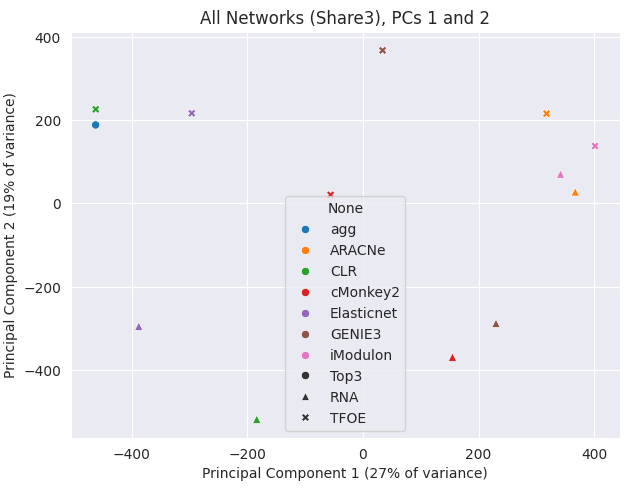

In [33]:
pca1 = PCA()
feature_df_scaled = StandardScaler().fit_transform(feature_share3_df.T) # pass in samples x features, returns samples x features
projection1 = pca1.fit_transform(feature_df_scaled)
# projection1 = pca1.fit_transform(((feature_df - feature_df.mean(axis='index')) / feature_df.std(axis='index')).T) # pass in samples x features
print('Projection:', projection1.shape)                                                                           # returns samples x components

pca_var1 = np.cumsum(pca1.explained_variance_ratio_)
k_comp1 = np.where(pca_var1 > 0.99)[0][0] + 1
print(f'Data: {len(feature_share3_df.index)} regulatory relationships x {len(feature_share3_df.columns)} networks')
print(f'Found {k_comp1} dimensions from PCA')

with sns.axes_style(style='darkgrid'):
    ax = sns.scatterplot(x=projection1[:,0], y=projection1[:,1],
        hue=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
        style=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
        markers={
            'Top3': 'o',
            'TFOE': 'X',
            'RNA': '^',
        },
    )
    ax.set_xlabel(f'Principal Component 1 ({pca1.explained_variance_ratio_[0]:.0%} of variance)')
    ax.set_ylabel(f'Principal Component 2 ({pca1.explained_variance_ratio_[1]:.0%} of variance)')
    plt.tight_layout()
    plt.title('All Networks (Share3), PCs 1 and 2');

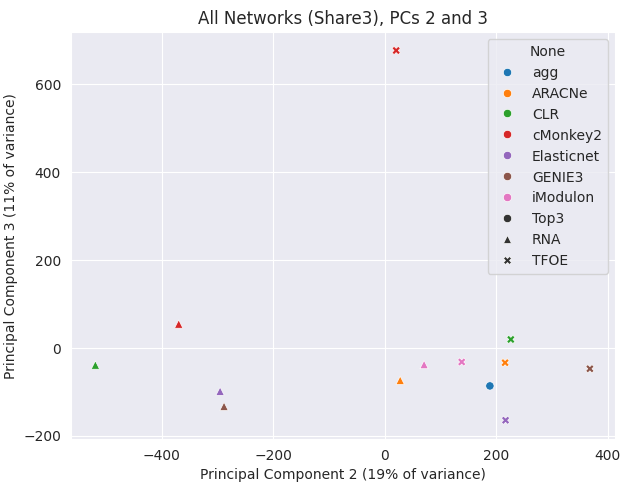

In [34]:
with sns.axes_style(style='darkgrid'):
    ax = sns.scatterplot(x=projection1[:,1], y=projection1[:,2],
        hue=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
        style=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
        markers={
            'Top3': 'o',
            'TFOE': 'X',
            'RNA': '^',
        },
    )
    ax.set_xlabel(f'Principal Component 2 ({pca1.explained_variance_ratio_[1]:.0%} of variance)')
    ax.set_ylabel(f'Principal Component 3 ({pca1.explained_variance_ratio_[2]:.0%} of variance)')
    plt.tight_layout()
    plt.title('All Networks (Share3), PCs 2 and 3');

Projection: (13, 13)
Data: 373167 regulatory relationships x 13 networks
Found 11 dimensions from PCA


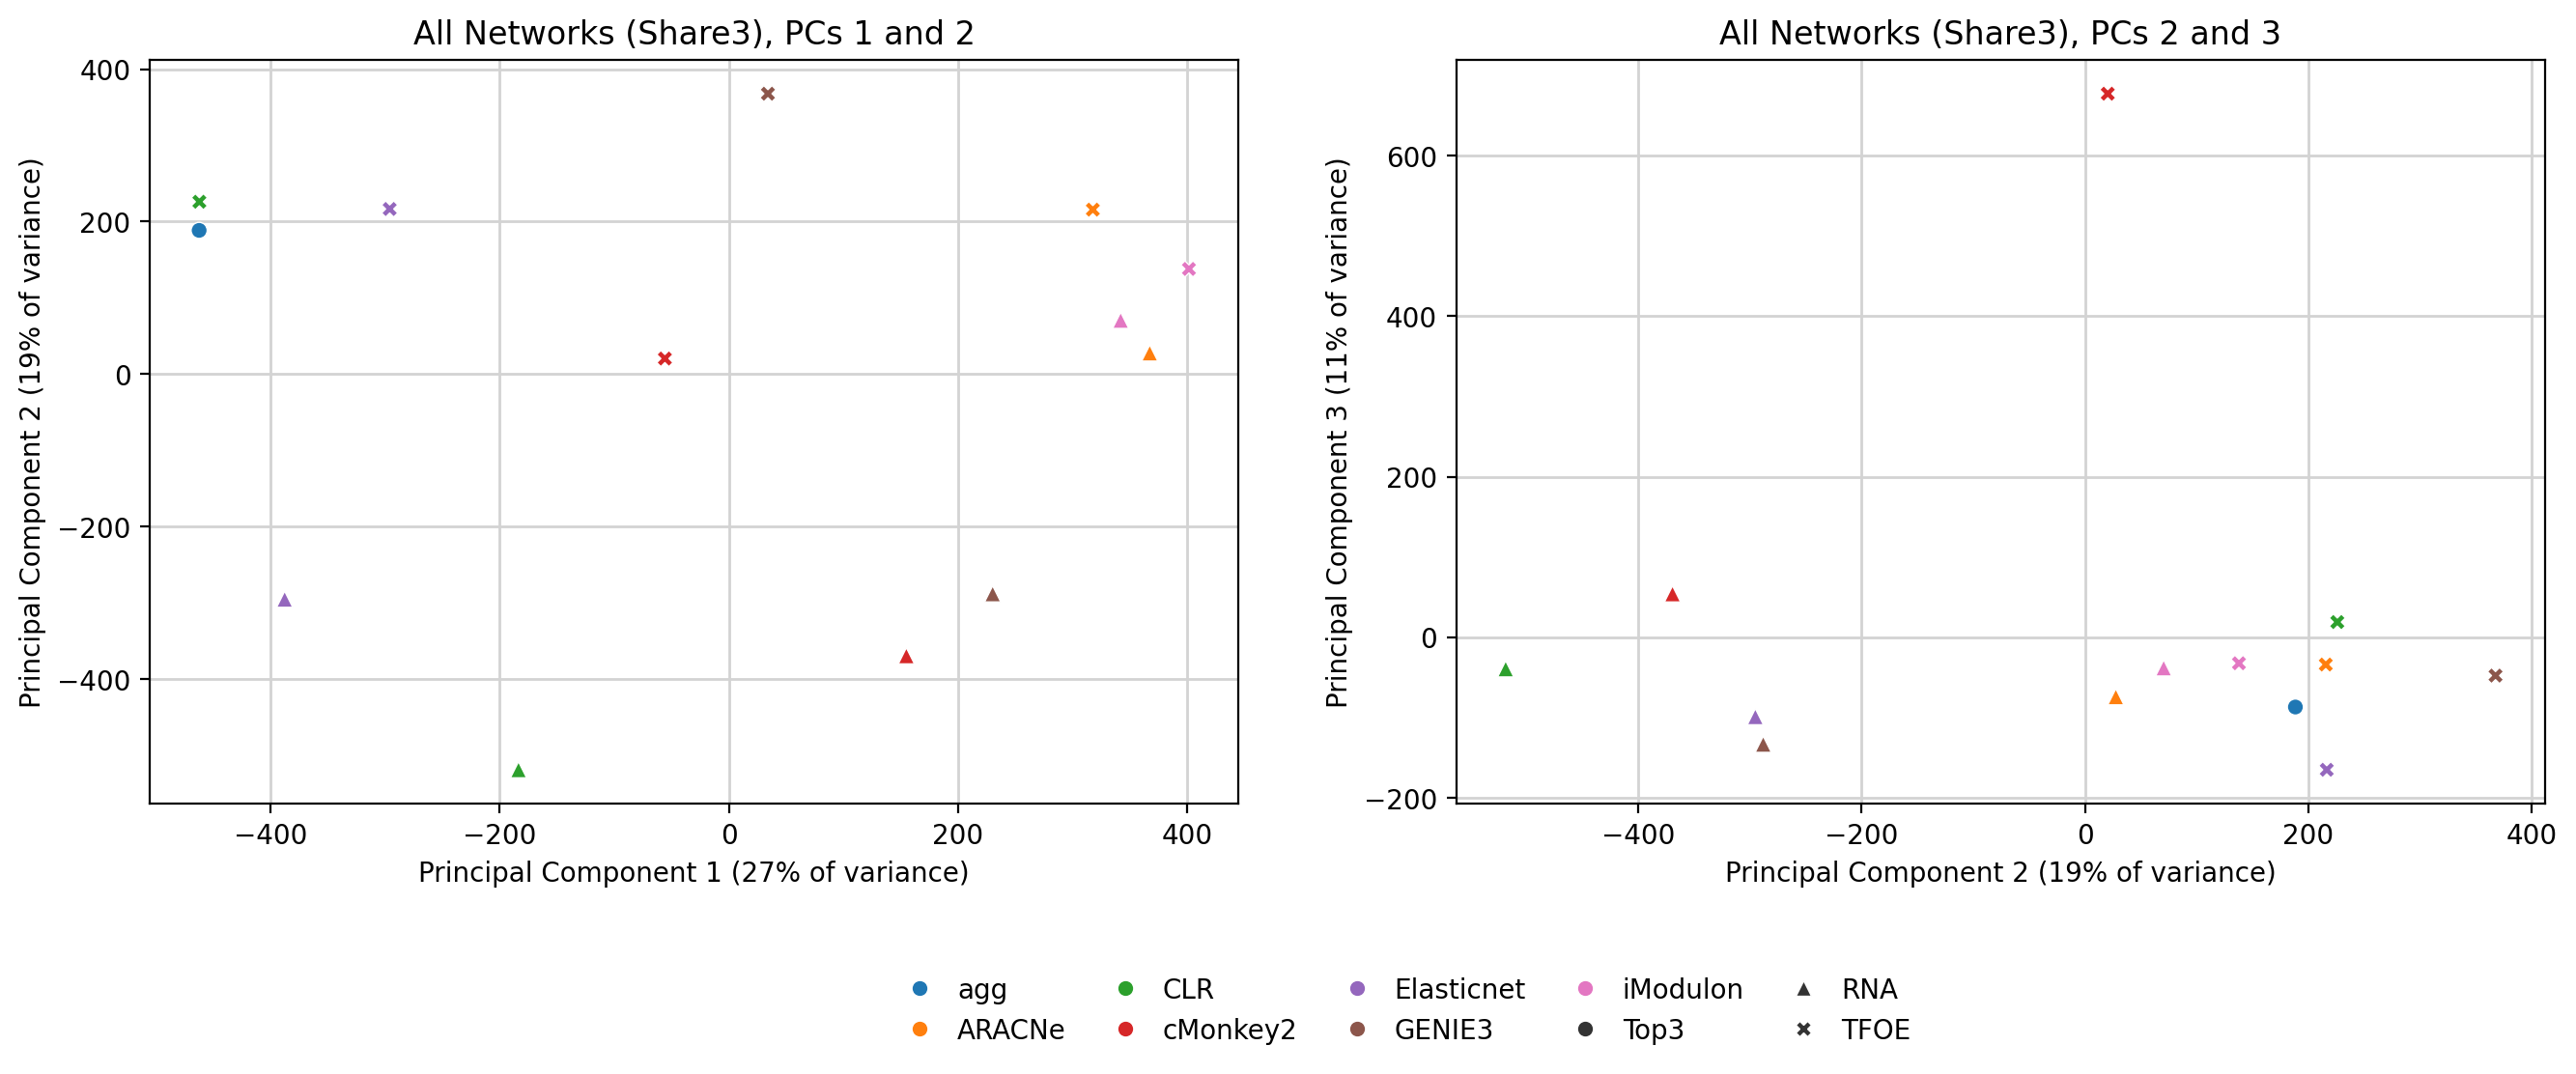

In [52]:
feature_share3_df = pd.DataFrame(index=shared_edge_sums[shared_edge_sums >= 3].index)

aggregates = {
    'agg_Top3': top3_network_df,
}

for label, network_df in aggregates.items():
    network_df = network_df.set_index(['Regulator', 'Gene'])
    intersection_idx = network_df.index.intersection(feature_share3_df.index)
    feature_share3_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share3_df.loc[feature_share3_df[label].isna(), label] = len(feature_share3_df)

for i, row in constituent_networks_df.iterrows():
    label = row['Method'] + '_' + row['Dataset']
    network_df = row['Edges_df'] # network already has index set to Regulator, Gene
    intersection_idx = network_df.index.intersection(feature_share3_df.index)
    feature_share3_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share3_df.loc[feature_share3_df[label].isna(), label] = len(feature_share3_df)

pca = PCA()
feature_df_scaled = StandardScaler().fit_transform(feature_share3_df.T) # pass in samples x features, returns samples x features
projection = pca.fit_transform(feature_df_scaled)
print('Projection:', projection.shape)                                 # returns samples x components

pca_var = np.cumsum(pca.explained_variance_ratio_)
k_comp = np.where(pca_var > 0.99)[0][0] + 1
print(f'Data: {len(feature_share3_df.index)} regulatory relationships x {len(feature_share3_df.columns)} networks')
print(f'Found {k_comp} dimensions from PCA')

fig = plt.figure(figsize=(16, 5), dpi=200)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True).flatten()

for ax in axs:
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)
    ax.yaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)

ax = sns.scatterplot(x=projection[:,0], y=projection[:,1],
    hue=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    legend=False, ax=axs[0],
)
ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
# plt.tight_layout()
ax.set_title('All Networks (Share3), PCs 1 and 2');

ax = sns.scatterplot(x=projection[:,1], y=projection[:,2],
    hue=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share3_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    ax=axs[1],
)
ax.set_xlabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 3 ({pca.explained_variance_ratio_[2]:.0%} of variance)')
# plt.tight_layout()
ax.set_title('All Networks (Share3), PCs 2 and 3');

sns.move_legend(
    ax, 'upper center', bbox_to_anchor=(-0.05, -0.2), ncols=5,
    fontsize='medium', frameon=False, title=None, handletextpad=0.4, columnspacing=1.2)

---

Projection: (13, 13)
Data: 115696 regulatory relationships x 13 networks
Found 11 dimensions from PCA


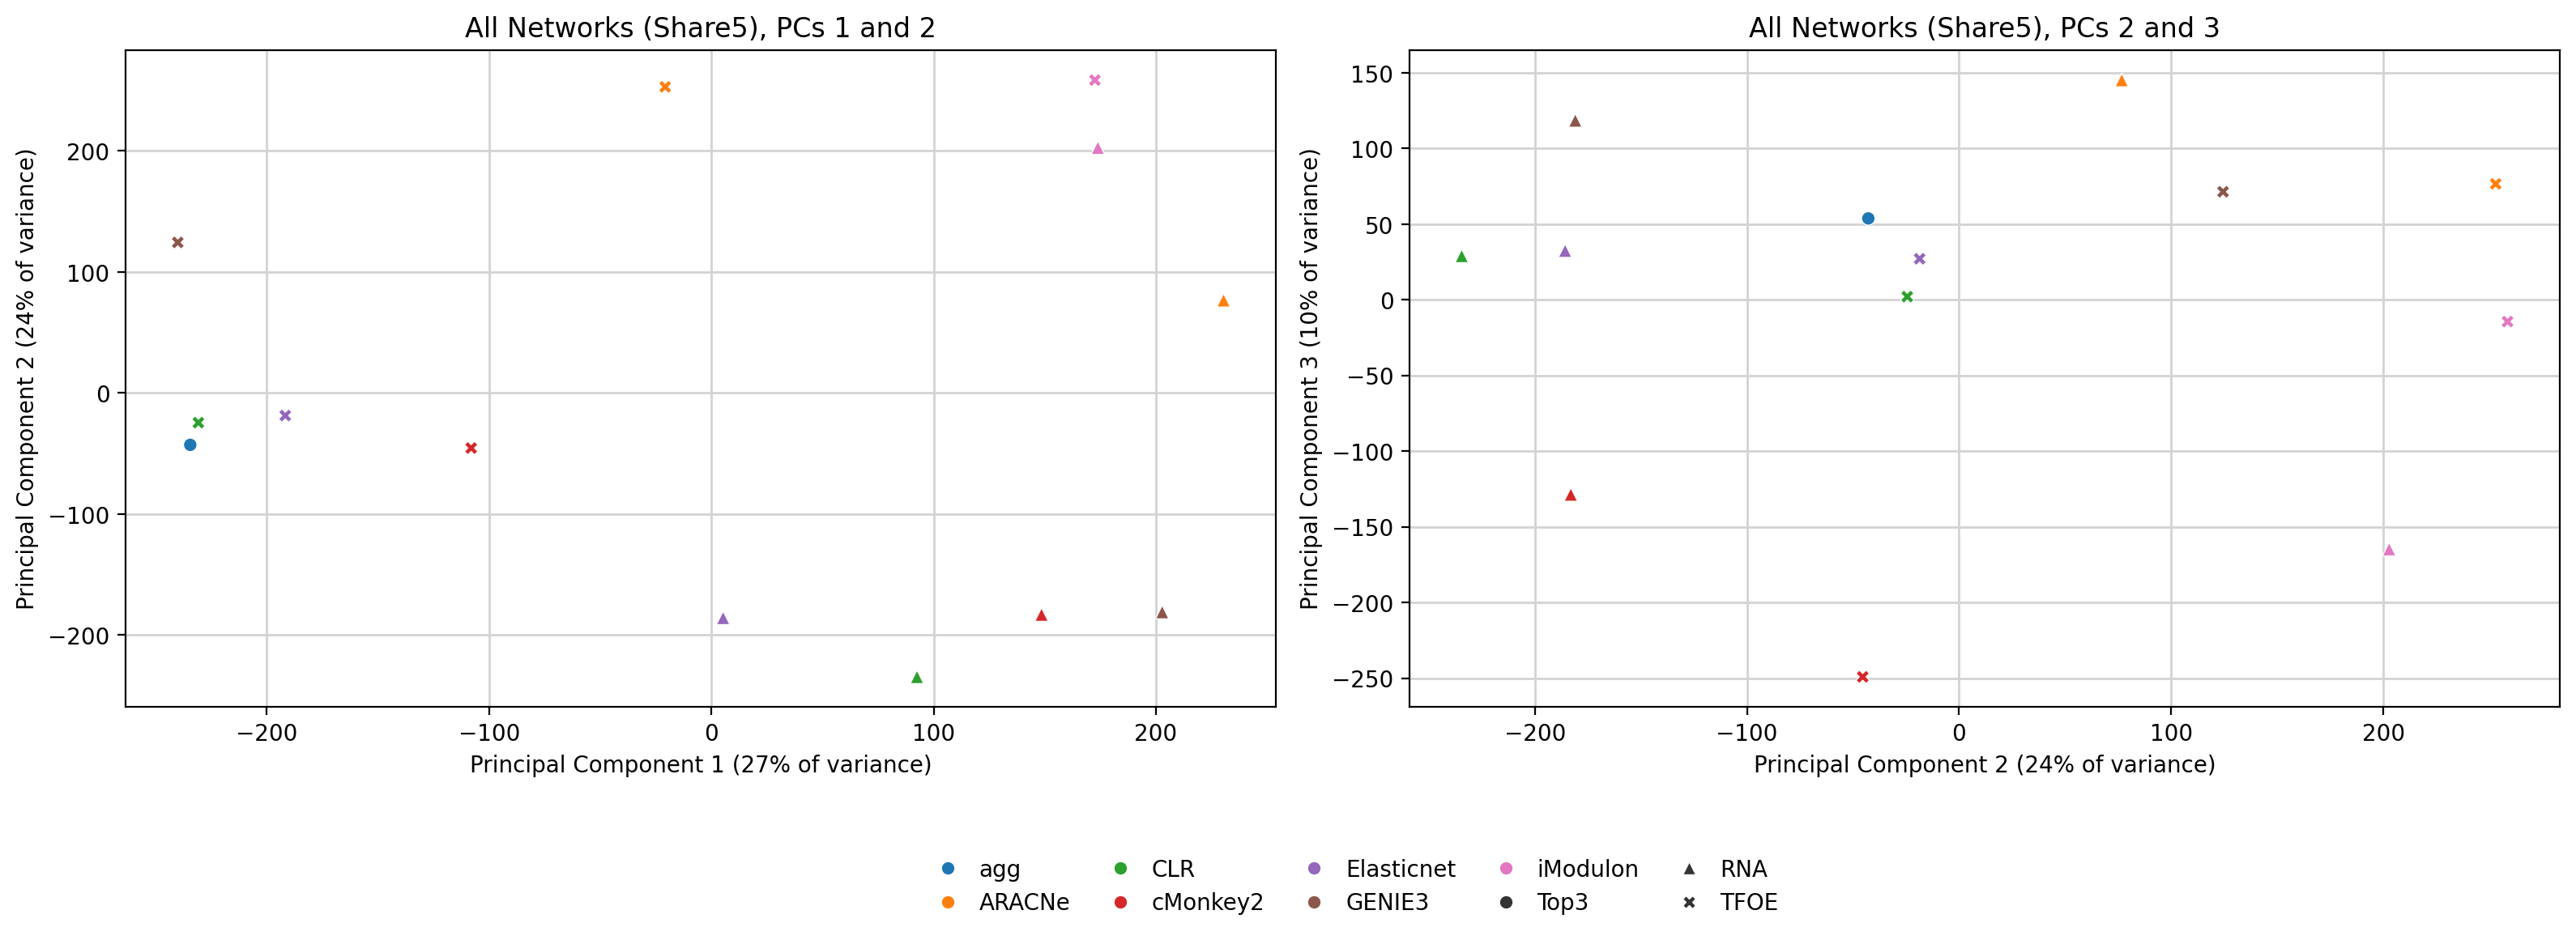

In [53]:
feature_share5_df = pd.DataFrame(index=shared_edge_sums[shared_edge_sums >= 5].index)

aggregates = {
    'agg_Top3': top3_network_df,
}

for label, network_df in aggregates.items():
    network_df = network_df.set_index(['Regulator', 'Gene'])
    intersection_idx = network_df.index.intersection(feature_share5_df.index)
    feature_share5_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share5_df.loc[feature_share5_df[label].isna(), label] = len(feature_share5_df)

for i, row in constituent_networks_df.iterrows():
    label = row['Method'] + '_' + row['Dataset']
    network_df = row['Edges_df'] # network already has index set to Regulator, Gene
    intersection_idx = network_df.index.intersection(feature_share5_df.index)
    feature_share5_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share5_df.loc[feature_share5_df[label].isna(), label] = len(feature_share5_df)

pca = PCA()
feature_df_scaled = StandardScaler().fit_transform(feature_share5_df.T) # pass in samples x features, returns samples x features
projection = pca.fit_transform(feature_df_scaled)
print('Projection:', projection.shape)                                 # returns samples x components

pca_var = np.cumsum(pca.explained_variance_ratio_)
k_comp = np.where(pca_var > 0.99)[0][0] + 1
print(f'Data: {len(feature_share5_df.index)} regulatory relationships x {len(feature_share5_df.columns)} networks')
print(f'Found {k_comp} dimensions from PCA')

fig = plt.figure(figsize=(16, 5), dpi=200)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True).flatten()

for ax in axs:
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)
    ax.yaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)

ax = sns.scatterplot(x=projection[:,0], y=projection[:,1],
    hue=feature_share5_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share5_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    legend=False, ax=axs[0],
)
ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
plt.tight_layout()
ax.set_title('All Networks (Share5), PCs 1 and 2');

ax = sns.scatterplot(x=projection[:,1], y=projection[:,2],
    hue=feature_share5_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share5_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    ax=axs[1],
)
ax.set_xlabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 3 ({pca.explained_variance_ratio_[2]:.0%} of variance)')
plt.tight_layout()
ax.set_title('All Networks (Share5), PCs 2 and 3');

sns.move_legend(
    ax, 'upper center', bbox_to_anchor=(-0.05, -0.2), ncols=5,
    fontsize='medium', frameon=False, title=None, handletextpad=0.4, columnspacing=1.2)

---

Projection: (13, 13)
Data: 30755 regulatory relationships x 13 networks
Found 11 dimensions from PCA


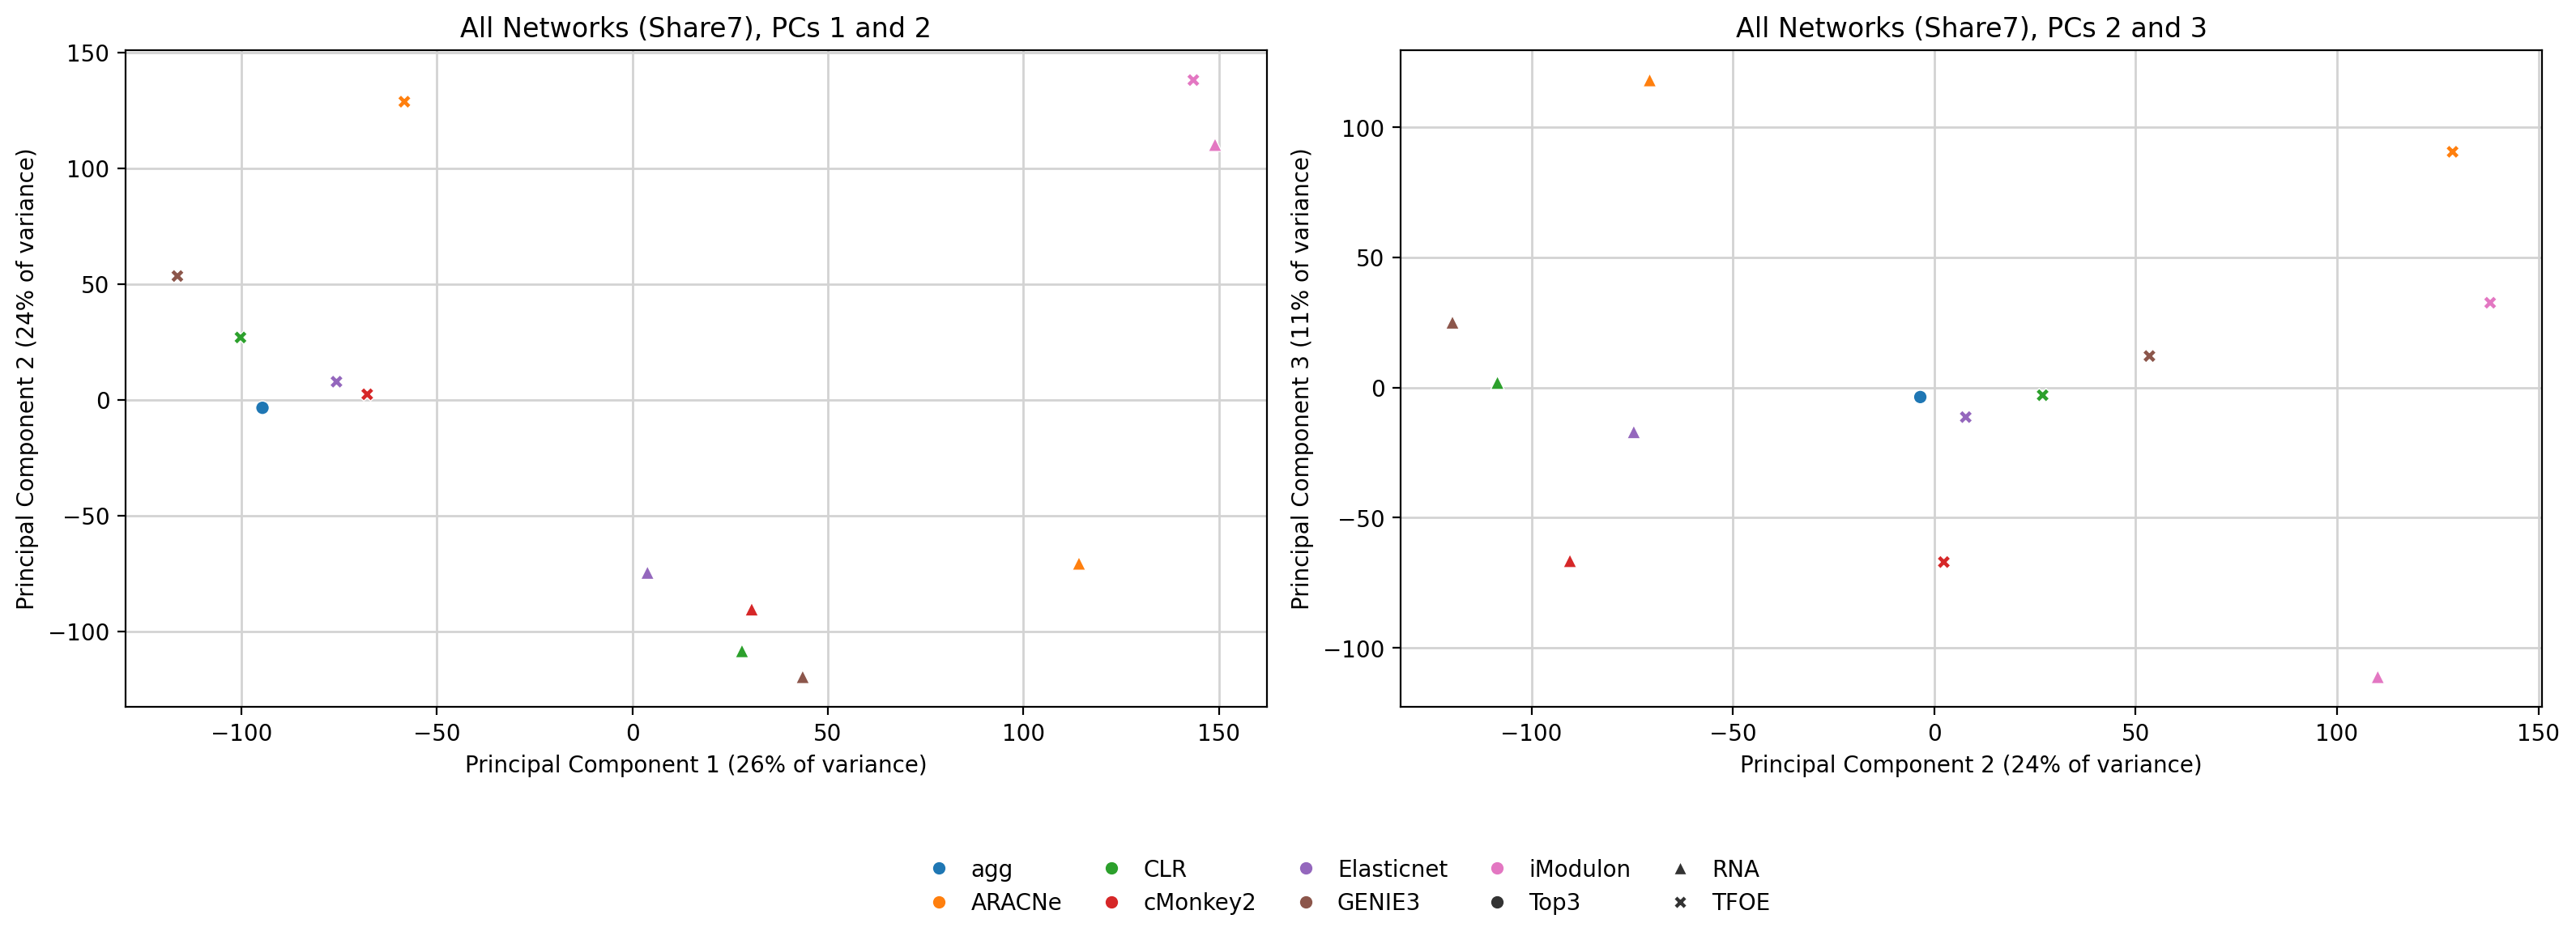

In [54]:
feature_share7_df = pd.DataFrame(index=shared_edge_sums[shared_edge_sums >= 7].index)

aggregates = {
    'agg_Top3': top3_network_df,
}

for label, network_df in aggregates.items():
    network_df = network_df.set_index(['Regulator', 'Gene'])
    intersection_idx = network_df.index.intersection(feature_share7_df.index)
    feature_share7_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share7_df.loc[feature_share7_df[label].isna(), label] = len(feature_share7_df)

for i, row in constituent_networks_df.iterrows():
    label = row['Method'] + '_' + row['Dataset']
    network_df = row['Edges_df'] # network already has index set to Regulator, Gene
    intersection_idx = network_df.index.intersection(feature_share7_df.index)
    feature_share7_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share7_df.loc[feature_share7_df[label].isna(), label] = len(feature_share7_df)

pca = PCA()
feature_df_scaled = StandardScaler().fit_transform(feature_share7_df.T) # pass in samples x features, returns samples x features
projection = pca.fit_transform(feature_df_scaled)
print('Projection:', projection.shape)                                 # returns samples x components

pca_var = np.cumsum(pca.explained_variance_ratio_)
k_comp = np.where(pca_var > 0.99)[0][0] + 1
print(f'Data: {len(feature_share7_df.index)} regulatory relationships x {len(feature_share7_df.columns)} networks')
print(f'Found {k_comp} dimensions from PCA')

fig = plt.figure(figsize=(16, 5), dpi=200)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True).flatten()

for ax in axs:
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)
    ax.yaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)

ax = sns.scatterplot(x=projection[:,0], y=projection[:,1],
    hue=feature_share7_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share7_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    legend=False, ax=axs[0],
)
ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
plt.tight_layout()
ax.set_title('All Networks (Share7), PCs 1 and 2');

ax = sns.scatterplot(x=projection[:,1], y=projection[:,2],
    hue=feature_share7_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share7_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    ax=axs[1],
)
ax.set_xlabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 3 ({pca.explained_variance_ratio_[2]:.0%} of variance)')
plt.tight_layout()
ax.set_title('All Networks (Share7), PCs 2 and 3');

sns.move_legend(
    ax, 'upper center', bbox_to_anchor=(-0.05, -0.2), ncols=5,
    fontsize='medium', frameon=False, title=None, handletextpad=0.4, columnspacing=1.2)

---

Projection: (13, 13)
Data: 105 regulatory relationships x 13 networks
Found 11 dimensions from PCA


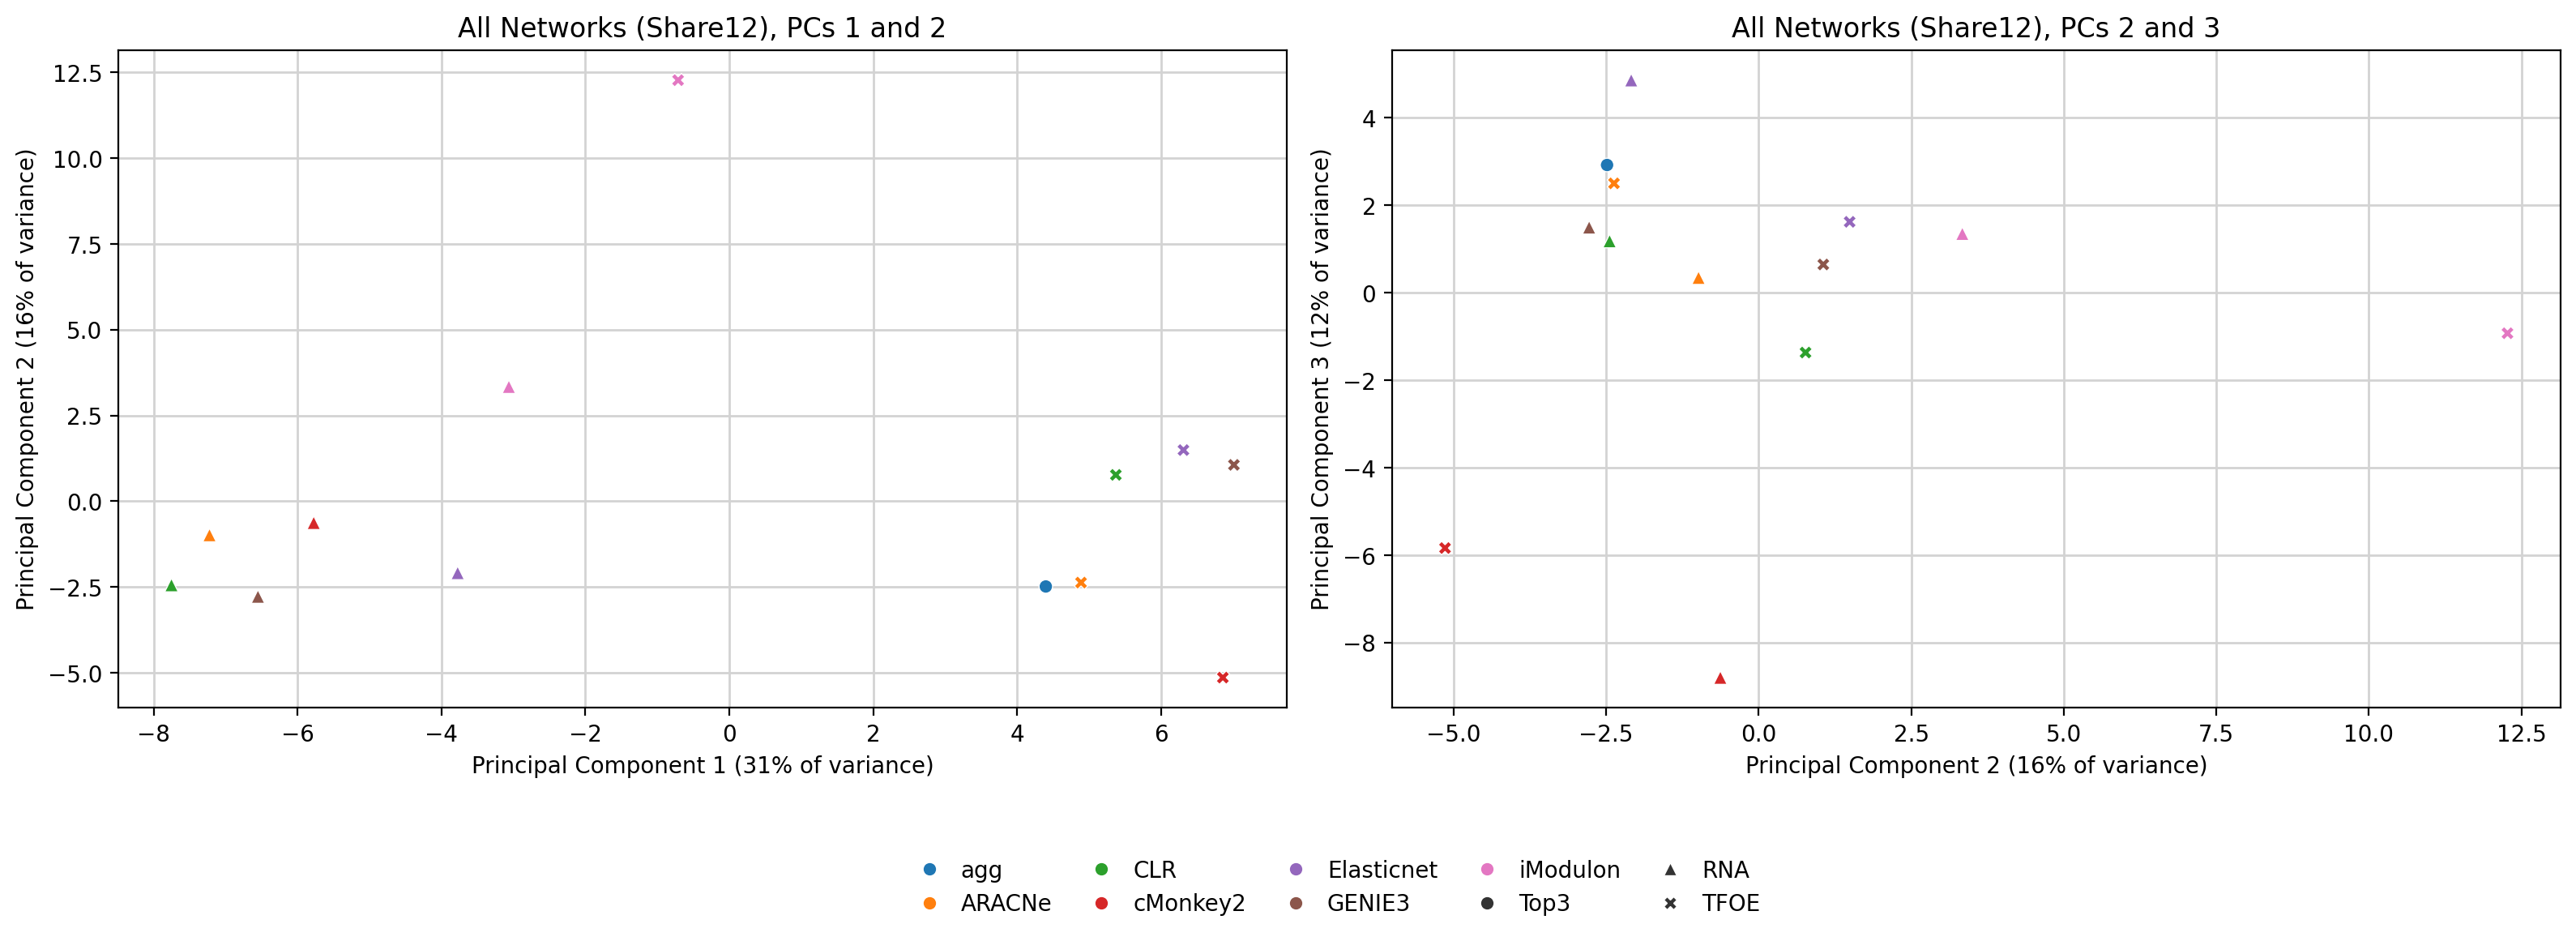

In [55]:
feature_share12_df = pd.DataFrame(index=shared_edge_sums[shared_edge_sums >= 12].index)

aggregates = {
    'agg_Top3': top3_network_df,
}

for label, network_df in aggregates.items():
    network_df = network_df.set_index(['Regulator', 'Gene'])
    intersection_idx = network_df.index.intersection(feature_share12_df.index)
    feature_share12_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share12_df.loc[feature_share12_df[label].isna(), label] = len(feature_share12_df)

for i, row in constituent_networks_df.iterrows():
    label = row['Method'] + '_' + row['Dataset']
    network_df = row['Edges_df'] # network already has index set to Regulator, Gene
    intersection_idx = network_df.index.intersection(feature_share12_df.index)
    feature_share12_df.loc[intersection_idx, label] = network_df.loc[intersection_idx, 'Rank'].rank(ascending=True)
    feature_share12_df.loc[feature_share12_df[label].isna(), label] = len(feature_share12_df)

pca = PCA()
feature_df_scaled = StandardScaler().fit_transform(feature_share12_df.T) # pass in samples x features, returns samples x features
projection = pca.fit_transform(feature_df_scaled)
print('Projection:', projection.shape)                                 # returns samples x components

pca_var = np.cumsum(pca.explained_variance_ratio_)
k_comp = np.where(pca_var > 0.99)[0][0] + 1
print(f'Data: {len(feature_share12_df.index)} regulatory relationships x {len(feature_share12_df.columns)} networks')
print(f'Found {k_comp} dimensions from PCA')

fig = plt.figure(figsize=(16, 5), dpi=200)
axs = fig.subplots(nrows=1, ncols=2, sharex=False, sharey=False, squeeze=True).flatten()

for ax in axs:
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)
    ax.yaxis.grid(True, which='major', color='lightgrey', ls='-', lw=1)

ax = sns.scatterplot(x=projection[:,0], y=projection[:,1],
    hue=feature_share12_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share12_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    legend=False, ax=axs[0],
)
ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
plt.tight_layout()
ax.set_title('All Networks (Share12), PCs 1 and 2');

ax = sns.scatterplot(x=projection[:,1], y=projection[:,2],
    hue=feature_share12_df.columns.to_series().map(lambda label: label.split('_')[0]), # hue represents Method
    style=feature_share12_df.columns.to_series().map(lambda label: label.split('_')[1]), # style represents Dataset
    markers={
        'Top3': 'o',
        'TFOE': 'X',
        'RNA': '^',
    },
    ax=axs[1],
)
ax.set_xlabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]:.0%} of variance)')
ax.set_ylabel(f'Principal Component 3 ({pca.explained_variance_ratio_[2]:.0%} of variance)')
plt.tight_layout()
ax.set_title('All Networks (Share12), PCs 2 and 3');

sns.move_legend(
    ax, 'upper center', bbox_to_anchor=(-0.05, -0.2), ncols=5,
    fontsize='medium', frameon=False, title=None, handletextpad=0.4, columnspacing=1.2)